# Importing Packages


In [1]:
%matplotlib inline
import os
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import nilearn
import nibabel as nib
import sklearn
import bct
import networkx
import warnings

C:\Users\majd\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading Atlases

In [2]:
import nilearn.datasets as dataset
Atlases={
         'MSDL':dataset.fetch_atlas_msdl(),
         'Harvard-Oxford':dataset.fetch_atlas_harvard_oxford('cort-prob-1mm'),
         'AAL': dataset.fetch_atlas_aal(),
         'BASC': dataset.fetch_atlas_basc_multiscale_2015(version='sym'),
         'Power': dataset.fetch_coords_power_2011(),
         'Dosenbach':dataset.fetch_coords_dosenbach_2010(ordered_regions=True),
        }

C:\Users\majd\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
C:\Users\majd\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
C:\Users\majd\Anaconda3\lib\site-packages\numpy\core\records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


# Loading Subjects 

In [3]:
def load_data(subj_list,location='/home/majd/Downloads'):
    
    """
    Loads resting-state images from provided path
    
    Parameters
    ----------
    subj_list: List of subjects' labels
    
    location: path to root folder containing all subjects data
    
    Returns
    -------
    func_filename: functional Image file
    confounds: tsv files containing confounds
    """
    
    func_filename=[nib.load('%s/%s'%(location,name)) 
                for name in subj_list]
    
    confound=['%s/%s_task-rest_bold_confounds.tsv'%(location,name)]
    
    return func_filename

# Extracting BOLD Time series 

In [4]:
import nilearn.datasets as dataset
from nilearn.input_data import NiftiLabelsMasker , NiftiMapsMasker , NiftiSpheresMasker
from nilearn.datasets import load_mni152_template,load_mni152_brain_mask
brainmask = load_mni152_brain_mask()

def signal_extract(data,atlas,masker_type='Spheres',saveas='file'):
    
    """
    Extracts BOLD time-series from resting-state preprocessed Images
    
    Parameters
    ----------
    data: Filenames of subjects. 
    
    atlas: regions or coordinates to extract signals from.
    
    masker_type : Type of masker used to extract BOLD signals . types are : 'Spheres','Maps','Labels'
    
    saveas : Destination to save and load output (.npz)
    
    Returns
    ---------
    subject_ts : array-like , 2-D (n_subjects,n_regions)
                 Array of BOLD time-series 
    """
    subjects_ts=[]
    
    if os.path.exists(saveas):
        
        subjects_ts=np.load(saveas)['arr_0']
        
    else:
        
        if masker_type== 'Spheres':
            masker = NiftiSpheresMasker(
                            seeds=atlas, smoothing_fwhm=6, radius=4 ,mask_img=brainmask,
                            detrend=False, standardize=True, low_pass=0.09, high_pass=0.008, t_r=2.2)
        elif masker_type == 'Maps':
            masker = NiftiMapsMasker(maps_img=atlas,mask_img=brainmask,standardize=True,
                                 high_pass=None,low_pass=None,detrend=True,t_r=2.2,
                                 resampling_target='data',
                                 verbose=5)
        elif masker_type == 'Labels':
            masker = NiftiLabelsMasker(labels_img=atlas,mask_img=brainmask,standardize=True,
                                 high_pass=0.01,low_pass=0.1,detrend=False,t_r=2.2,
                                 memory_level=2,smoothing_fwhm=5,resampling_target='data',
                                 memory=mem,verbose=5)
        else:
            raise ValueError("Please provide masker type")
            
        for func_file in data:
            time_series = masker.fit_transform(func_file)
            subjects_ts.append(time_series)
            np.savez(saveas,subjects_ts)
            
    return subjects_ts

# Loading subject's time-series

In [5]:
sub_list=['01','02','04','05','06','07','08','09','11','14']

subjects_ts_AP={}
for r in np.arange(1,3):
    subjects_ts_AP['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_AP['run_%0d'%r].append(np.load('/Users/majd/Desktop/PhD/Analysis'+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-AP_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])
        
subjects_ts_PA={}
for r in np.arange(1,3):
    subjects_ts_PA['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_PA['run_%0d'%r].append(np.load('/Users/majd/Desktop/PhD/Analysis'+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-PA_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])


# Computing Functional Connectivity

In [6]:
from sklearn.covariance import LedoitWolf , OAS , GraphLassoCV , EmpiricalCovariance
kinds=['correlation','partial correlation','covariance']
from nilearn.connectome import ConnectivityMeasure 
def connectivity(subjects_ts,kinds=kinds,saveas='file'):
    
    """
    Parameters
    ----------
    subjects_ts: array-like , 2-D (n_subjects,n_regions)
                 Array of BOLD time-series  
    
    kinds: list of kinds of connectivity measure to be computed . kinds include : 
        ' correlation ' , ' partial correlation', ' tangent' , 'covariance' . 
                                                
    
    saveas : Destination to save and load output (.npz)
    
    Returns
    ---------
    mean_connectivity_matrix: dictionary ,  {'kind' : (n_regions,n_regions)} 
                              Group-level functional connectivity matrix
    individual_connectivity_matrix: dictionary , {'kind' : (n_subjects,n_regions,n_regions)}
                              Subject-level functional connectivity matrices
                 
    """
    
    individual_connectivity_matrices = dict()
    
    mean_connectivity_matrix = dict()
    
    if os.path.exists(saveas):
            data=np.load(saveas)
            individual_connectivity_matrices=data['arr_0'].flatten()[0] 
            mean_connectivity_matrix=data['arr_1'].flatten()[0]
    else:

        for kind in kinds:
            
            # Computing individual functional connectivity
            
            conn_measure = ConnectivityMeasure(cov_estimator=LedoitWolf(
                                               assume_centered=True, 
                                               store_precision=True), 
                                               kind=kind, 
                                               vectorize=False, discard_diagonal=False)
            
            individual_connectivity_matrices[kind]= conn_measure.fit_transform(subjects_ts)
            
            # Computing group functional connectivity
            
            if kind == 'tangent':
                mean_connectivity_matrix[kind] =  conn_measure.mean_
            else:
                mean_connectivity_matrix[kind] = \
                individual_connectivity_matrices[kind].mean(axis=0)
            np.savez(saveas,individual_connectivity_matrices,mean_connectivity_matrix)
            
    return mean_connectivity_matrix,individual_connectivity_matrices

# Two-sample t-test : Subnetwork Connections

In [7]:
def mat_upper_tri(matrix):
    mat_triu=np.zeros(int(matrix.shape[0]*(matrix.shape[0]-1)/2))
    cur_triu = (np.triu(matrix,1))
    mat_triu=cur_triu[np.triu_indices_from(cur_triu,1)]
    return mat_triu

def fisher_ztransfrom(matrix):  
        z_mat=[]
        curmat=mat_upper_tri(matrix)
        z_mat= np.arctanh(curmat)
        return z_mat
    
def t_test(c_data,p_data,shape=()):
    t,p=scipy.stats.ttest_ind(c_data,p_data)
    pmat= np.zeros(shape)
    pmat[np.triu_indices_from(pmat,1)]=p
    pmat= pmat + pmat.T
    tmat= np.zeros(shape)
    tmat[np.triu_indices_from(tmat,1)]=t
    tmat= tmat + tmat.T
    return pmat,p,t,tmat

#Thresholding and Binarizing P-value matrices
def mat_thresh_bin(matrix,thr=0.05,binarize=False):
    thrsh_mats=[]
    np.fill_diagonal(matrix,0)
    curmat = matrix.copy()
    high_values_flags = curmat > thr # Where values are higher than threshold
    curmat[high_values_flags] = 0    # All higher values set to 0
    if binarize:
        curmat[curmat>0]=1               # All remaining values set to 1
    thrsh_mats.append(curmat)
    return np.asarray(thrsh_mats[0])
#Plotting P-value matrices
def plot_t_test(p_thrsh,labels=None,cmap=None,title='file'):
    fig=plt.figure(figsize=(20,20))
    plt.imshow(p_thrsh,cmap=cmap,interpolation='nearest',vmin=-abs(p_thrsh.max()),vmax=p_thrsh.max())
    plt.colorbar()
    plt.title(title,fontsize=30)
    x_ticks = plt.xticks(range(len(labels)),labels, rotation=90)
    y_ticks = plt.yticks(range(len(labels)),labels)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    plt.savefig(title,bbox_inches='tight')
    plt.show()

# Dynamic Connectivity Analysis

In [8]:
import nilearn.connectome
import numpy as np
from scipy import signal
import scipy.linalg 
from scipy.linalg import eigh
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN
from sklearn.covariance import EmpiricalCovariance,LedoitWolf,ShrunkCovariance,OAS
from pyriemann.clustering import Kmeans
from pyriemann.utils.base import sqrtm, invsqrtm, logm, expm
import statsmodels.stats.api as sms
from bct.algorithms.modularity import modularity_und
from bct.algorithms.modularity import community_louvain
from bct import grid_communities
def sliding_window_1d(a,ws=60,ss=1):
    """
    Computes Sliding-windows indices 
    
    Parameters
    ----------
    a:  array , 1-D (n_volumes)
    ws: window width
    ss: window step size, in samples. If not provided, window and step size are equal.
    
    Returns
    ----------
    out : array-like , 2-D (n_windows,ws)
          Vector with all sliding windows
    """ 
    if None is ss:
    # no step size was provided. Return non-overlapping windows
        ss = ws   
    # calculate the number of windows to return, ignoring leftover samples, and
    # allocate memory to contain the samples
    valid = len(a) - ws
    
    nw = abs((valid) // ss)
    
    out = np.ndarray((nw,ws),dtype = a.dtype)
    
    for i in range(nw):
        
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]
    
    return out

def taper(window,ws=60,wtype='tukey'):
    """
    Tapers rectangular window 
    
    Parameters
    ----------
    window : array-like , array of sliding window indices 
    ws: window width
    wtype: type of tapering function ( default : Tukey )
    
    Returns
    -------
    out :
    
    """
    if wtype == 'tukey':
        taper= scipy.signal.tukey(ws,alpha=0.5,sym=True)
      
    out=window*taper
    
    return out

def upper_tri(matrix):
        """
        Computes upper triangular form of a set of matrices
        
        Parameters
        ----------
        matrix: list of N x N matrices 
        
        Returns
        -------
        
        mat_triu: list of  NxN(N-1)/2 vectors
        """        
        mat_triu=[]
        for i,x in enumerate(matrix):
                cur_triu = (np.triu(x,1))
                mat_triu.append(cur_triu[np.triu_indices_from(cur_triu,1)])
        return mat_triu
    
def unupper_tri(V):
    """
        Computes matrix form of a set of upper triangular vectors
        
        Parameters
        ----------
        V: list of  NxN(N-1)/2 vectors
        
        Returns
        -------
        
        matrices : list of N x N matrices 
        """
    n_features=int((1+np.sqrt(1+8*V.shape[1]))//2)
    matrices= np.zeros((V.shape[0],n_features,n_features))
    for i,center in enumerate(V):
            curmat=np.zeros((n_features,n_features))
            curmat[np.triu_indices_from(curmat,1)]=center
            matrices[i] = curmat+curmat.T
    return matrices
    
        
def is_spd(A, tol=1e-8):
    """
    Parameters
    ----------
    A : Symmetrtic Square Matrix 
    
    Returns
    ---------
    Boolean True or False
    """
    E,V = scipy.linalg.eigh(A)
    return np.all(E > -tol),E

def untangent_space(T, Cref):
    """Project a set of Tangent space vectors in the manifold according to the given reference point Cref
    
    Parameters
    ----------
    T:    {array-like} ,The Tangent space , shape= ( NWindows X Mfeatures(*(Mfeatures-1)/2))
    
    Cref: {array-like} ,The reference covariance matrix (Mfeatures X Mfeatures )
    
    Returns
    ----------
    
    covmats: {array-like} ,(Mfeatures X Mfeatures)  SPD Matrice

    """
    Nt, Nd = T.shape
    Ne = (1+np.sqrt(1+8*Nd))/2
    C12 = sqrtm(Cref)
    idx = np.triu_indices_from(Cref,0)
    covmats = np.zeros((Nt, Ne, Ne))
    covmats[:, idx[0], idx[1]] = T
    for i in range(Nt):
        covmats[i] = np.diag(np.diag(covmats[i])) + np.triu(
            covmats[i], 0) + np.triu(covmats[i], 0).T 
        covmats[i] = expm(covmats[i])
        covmats[i] = np.dot(np.dot(C12, covmats[i]), C12)
    return covmats

def conn_highvariance(allcovdata):

    """ 
    -Identify windows with high variance in connectivity for each subject, 
    -calculate the average connectitivy (average of all edges)
    -Define a 95% confidence interval on this average 
    -Select data points outside (higher values)
    
    Parameters
    ----------
    allcovdata:{array-like} , Connectivity matrices of all subjects , 
                shape =(Subjects X NWindows X Mfeatures X Mfeatures )
    
    Returns
    ----------
    
    mtd_allsubj_highvar:{array-like} , All windows of High Variance , shape= (Windows X Mfeatures X Mfeatures)

    """
    mtd_allsubj_highvar = []
    
    # High variance windows for each subject 
    var_mtd_allsubj =[]
    
    for curcov in allcovdata:

        # calculate variance of MTD intra subject
        var_mtd_allsubj.append([a.mean() for a in curcov])

    # Extract points with high variance ( > 95 % confidence interval )
    for cur_i,curvarmtd in enumerate(var_mtd_allsubj):

        a = sms.DescrStatsW(curvarmtd)
        _,high= a.tconfint_mean()
        ind_highvar = np.argwhere(curvarmtd>high)

        # select the covdata for these points only
        curcov = allcovdata[cur_i]
        mtd_allsubj_highvar.append(curcov[ind_highvar])
    return np.vstack(mtd_allsubj_highvar)

def dfc_slid_window(X,ws=60,ss=1): 
        
        """
        Computes Sliding windows time-series for a set of Subjects
        
        Parameters
        ----------
        X: Array-like (MxNxS) containing subjects' region of ineterest BOLD time-series
        ws: window size (default=60)
        ss: sliding step size (default=1)
        
        Returns
        -------
        slwin_ts: Array-like (MxPxWSxN) containing sliding window time series per subject per region
        """
        nsubj=X.shape[0] # number of subjects
        nvolm=X.shape[1] # number of volumes
        nfeat=X.shape[2] # number of brain regions   
        slwin_ts=np.ndarray((nsubj,(nvolm-ws)//ss,ws,nfeat))
        for idx,s in enumerate(X):
            fulltimewin = np.arange(nvolm,dtype='int32')
            swins= sliding_window_1d(a=fulltimewin,ws=ws,ss=ss)
            n_slwin = swins.shape[0] #number of sliding windows
            slwin_ts[idx]=np.empty((n_slwin,ws,nfeat))
            for n, curwin in enumerate(swins):
                cur_ts = s[curwin,:]
                slwin_ts[idx][n]=np.ndarray((ws,nfeat))
                for i in range(nfeat):
                    slwin_ts[idx][n][:,i]= taper(cur_ts[:,i],ws)
        return slwin_ts,slwin_ts.shape[1]


class DynamicConnectivityMeasure():
    
    """ Dynamic Connectivity Estimator 
    Parameters
    -----------
    cov_estimator : Method of Estimating covariance/connectivity ( default= EmpiricalCovariance)
    n_states: Number of Dynamic Connectivity States
    ws: sliding window width
    ss: sliding window step size 
    kinds : list of connectivity measures
    
    Attributes
    -----------
    connectivity: {array-like}, Windowed Connectivity Measures for Subjects , 
                  shape=(n_subjects X n_windows X n_features X n_features)
    states : {array-like} ,Dynamic States , shape=(n_states , n_features , n_features)
    labels : {array-like} , Kmeans Labels, shape=(1 , n_windows)
    inertia : Kmeans inertia value
    mean_: {array_like}, Geometric mean for the tangent kind , shape=(n_features , n_features)
    
    """
    def __init__(self,cov_estimator=EmpiricalCovariance(store_precision=True, 
                 assume_centered=False),n_states=2,ws=60,ss=1,kinds=['correlation'],
                 saveas='file'):
        
        self.cov_estimator=cov_estimator
        self.n_states=n_states
        self.ws=ws
        self.ss=ss
        self.kinds=kinds        
        self.saveas=saveas
        
    
        
    def fit(self,X):
        
        """
        Parameters
        -----------
        X: {array-like}, shape = (n_subjects , n_volumes , n_features)
           resting state BOLD time-series for subjects
        
        Returns
        ----------
        self : object 
        
        """    
        if not os.path.exists(self.saveas):
            
            #Checking if input Time series Matrix is 2D for each subject
            subjects_types = [type(s) for s in X]
            if set(subjects_types) != set([np.ndarray]):
                raise ValueError("Each subject must be 2D numpy.ndarray.\n You "
                                 "provided {0}".format(str(subjects_types)))
                
            #Initializing   
            self.connectivity,self.states,self.labels,self.inertia=dict(),dict(),dict(),dict()
            connectivity=dict()
            nsubj=X.shape[0] # number of subjects
            nvolm=X.shape[1] # number of volumes
            nfeat=X.shape[2] # number of brain regions  
            ws=self.ws
            ss=self.ss
            
            #Estimating Dynamic Connectivity
            for kind in self.kinds:
                estimator = nilearn.connectome.ConnectivityMeasure(kind=kind,cov_estimator=self.cov_estimator,
                                                                   vectorize=True,discard_diagonal=True)
                
                slwin_ts,n_slwin=dfc_slid_window(X,ws=ws,ss=ss) # Windowed BOLD time-series
                connectivity[kind] = np.ndarray((nsubj*n_slwin,(nfeat*(nfeat-1))//2))     
                connectivity[kind] = estimator.fit_transform(slwin_ts.reshape(nsubj*n_slwin,ws,nfeat))
                
                #Extracting matrices with high-variance
                highvar_mats=connectivity[kind].reshape(nsubj,n_slwin,(nfeat*(nfeat-1))//2)
                highvar_mats=np.vstack(conn_highvariance(highvar_mats))
                
                
                # 2-level KMeans clustering
                clustering_lvl_1=KMeans(n_clusters=self.n_states, init='k-means++', n_init=150, max_iter=300, 
                                       precompute_distances='auto', verbose=0, random_state=None, 
                                       copy_x=True, algorithm='auto').fit(highvar_mats) # 1st level
                
                clustcenters=clustering_lvl_1.cluster_centers_ # 1st level cluster centers
                
                clustering_lvl_2=KMeans(n_clusters=self.n_states, init=clustcenters, max_iter=300, 
                                       precompute_distances='auto', verbose=0, random_state=None, 
                                       copy_x=True, algorithm='auto').fit(connectivity[kind]) # 2nd level
                
                
                #Finalizing
                self.connectivity[kind]= unupper_tri(connectivity[kind])
                self.states[kind] =unupper_tri(clustering_lvl_2.cluster_centers_)
                self.labels[kind]= clustering_lvl_2.labels_.reshape(nsubj,n_slwin)
                self.inertia[kind]=clustering_lvl_2.inertia_
                
                #Projecting from Tangent space to SPD for the tangent kind 
                if kind=='tangent':
                    self.mean_=unupper_tri(estimator.mean_)
                    self.states[kind]=untangent_space(self.states[kind],Cref=self.mean_) 
                    
            np.savez(self.saveas,self)    
        
        else:
            data=np.load(self.saveas)
            self=data['arr_0'].flatten()[0] 
                        
        return self

C:\Users\majd\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Determining the number of Clusters

In [9]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from scipy .stats.mstats import zscore
from sklearn.metrics import silhouette_score

def elbow(data,K_range=range(1,20)):
    data=upper_tri(data)
    data=np.asarray(data)
    avgWithinSS=[]
    for k in K_range:
        kmeanModel = KMeans(n_clusters=k).fit(data)
        clusters=kmeanModel.cluster_centers_
        avgWithinSS.append(sum(np.min(cdist(data, clusters, 'euclidean'), axis=1)) / data.shape[0])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.plot(K_range, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.savefig('average com')
    plt.show()
    
def silhouette(data,K_range=range(2,20)):
    s = []
    data=upper_tri(data)
    data=np.asarray(data)
    for k in K_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        s.append(silhouette_score(data, labels, metric='euclidean'))
    fig=plt.figure(figsize=(15,15))
    plt.plot(K_range,s)
    plt.ylabel("Silhouette")
    plt.xlabel("k")
    plt.title("Silhouette for K-means cell's behaviour")
    plt.savefig('Silhouette Kmeans')
    plt.show()

# Dwell time and Frequency for each state on Subject- and Group- Level

In [10]:
mods=['correlation']
def freq_dwell(labels,n_states=5,mods=mods):
    counter,trans,dwell,freq,grp_freq,grp_dwell={},{},{},{},{},{}
    for mod in mods:
        n_subj=labels[mod].shape[0]
        counter[mod]=np.zeros((n_subj,n_states))
        trans[mod]=np.ones((n_subj,n_states))
        dwell[mod]=np.zeros((n_subj,n_states))
        freq[mod]=np.zeros((n_subj,n_states))
        for i in range(n_subj):
            val_old=0
            for  val in labels[mod][i]:
                for j in np.arange(0,n_states):
                    if val == j:
                        counter[mod][i,j] = counter[mod][i,j] +1          
                    if val != val_old and val==j:
                        trans[mod][i,j] += 1
                val_old=val          
        dwell[mod]= counter[mod]/trans[mod]
        freq[mod]=counter[mod]*100/labels[mod][i].shape[0]
        grp_freq[mod]=np.ceil(freq[mod].mean(axis=0))
        grp_dwell[mod]=np.ceil(dwell[mod].mean(axis=0))
    return dwell,freq,grp_dwell,grp_freq

# Plotting Dynamic Connectivity States and the Corresponding Group Dwell time and Frequency of Occurrence

In [20]:
def plot_dfc(states,grp_dwell,grp_freq,mod='correlation',labels=None,title='DFC'):
    fig=plt.figure(figsize=(20,20))
    for i,s in enumerate(states[mod]):
        np.fill_diagonal(s,0)
        ax=fig.add_subplot(3,3,i+1) 
        if grp_dwell and grp_freq is not None:
            ax.set_title("state %d \n Mean Dwell Time: " %(i+1) + 
                            "%.f TR \n Mean frequency: %d %% "
                            %(grp_dwell[mod][i],grp_freq[mod][i]),fontsize=18)
        im=plt.imshow(s, interpolation='nearest', cmap=plt.cm.RdBu_r)
        plt.colorbar(im, fraction=0.07, pad=0.04)
        if labels is not None:
            x_ticks = plt.xticks(range(len(labels)),labels, rotation=90)
            y_ticks = plt.yticks(range(len(labels)),labels)
            plt.rc('xtick', labelsize=10) 
            plt.rc('ytick', labelsize=10)
        fig.suptitle(title,fontsize=30)
        fig.subplots_adjust(hspace=1,wspace=0.4)
        plt.savefig(title,bbox_inches='tight') 
    plt.show()

# Example : MPI-Leipzig_Mind-Brain-Body Data

In [26]:
### Loading Parcellated data for 10 subjects over 4 runs for each subject
sub_list=['01','02','04','05','06','07','08','09','11','14']

subjects_ts_AP={}
for r in np.arange(1,3):
    subjects_ts_AP['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_AP['run_%0d'%r].append(np.load('/Users/majd/Desktop/PhD/Analysis'+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-AP_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])
        
subjects_ts_PA={}
for r in np.arange(1,3):
    subjects_ts_PA['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_PA['run_%0d'%r].append(np.load('/Users/majd/Desktop/PhD/Analysis'+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-PA_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])
        
### Computing Stationary Connectivity 



### Computing Dynamic Connectivity states for each run across all subjects

dfc_AP={}
for r in np.arange(1,3):
    dfc_AP['run_0%d'%r]=DynamicConnectivityMeasure(n_states=3,ws=60,ss=1,kinds=['correlation'],
                                    cov_estimator=LedoitWolf(),
                                    saveas='dfc_AP_0%d.npz'%r).fit(np.array(subjects_ts_AP['run_%0d'%r]))
dfc_PA={}
for r in np.arange(1,3):
    dfc_PA['run_0%d'%r]=DynamicConnectivityMeasure(n_states=3,ws=60,ss=1,kinds=['correlation'],
                                    cov_estimator=LedoitWolf(),
                                    saveas='dfc_PA_0%d.npz'%r).fit(np.array(subjects_ts_PA['run_%0d'%r]))
    
### Computing Dwell time and frequency of occurrence of each state in each run 

mods=['correlation']
dwell_AP,freq_AP,grp_dwell_AP,grp_freq_AP={},{},{},{}

for r in np.arange(1,3):
    dwell_AP['run_0%d'%r],freq_AP['run_0%d'%r],grp_dwell_AP['run_0%d'%r],grp_freq_AP['run_0%d'%r]=freq_dwell(dfc_AP['run_0%d'%r].labels,
                                                                                                             n_states=3,mods=mods)
    
dwell_PA,freq_PA,grp_dwell_PA,grp_freq_PA={},{},{},{}
for r in np.arange(1,3):
    dwell_PA['run_0%d'%r],freq_PA['run_0%d'%r],grp_dwell_PA['run_0%d'%r],grp_freq_PA['run_0%d'%r]=freq_dwell(dfc_PA['run_0%d'%r].labels,
                                                                                                             n_states=3,mods=mods) 

### Assessing Cosine Similarity between states in each run and rearranging 

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

data_PA_1=upper_tri(dfc_PA['run_01'].states['correlation'])
data_PA_2=upper_tri(dfc_PA['run_02'].states['correlation'])

data_AP_1=upper_tri(dfc_AP['run_01'].states['correlation'])
data_AP_2=upper_tri(dfc_AP['run_02'].states['correlation'])

simil_PA=cosine_similarity(data_PA_1,data_PA_2)
simil_AP=cosine_similarity(data_AP_1,data_AP_2)
simil_AP_PA=cosine_similarity(data_AP_1,data_PA_1)

order_PA=np.argmax(cosine_similarity(data_PA_1,data_PA_2),axis=1)
order_AP=np.argmax(cosine_similarity(data_AP_1,data_AP_2),axis=1)
order_AP_PA=np.argmax(cosine_similarity(data_AP_1,data_PA_1),axis=1)
dfc_PA['run_02'].states['correlation']=dfc_PA['run_02'].states['correlation'][order_PA]
dfc_AP['run_02'].states['correlation']=dfc_AP['run_02'].states['correlation'][order_AP]
dfc_PA['run_02'].states['correlation']=dfc_PA['run_02'].states['correlation'][order_AP_PA]

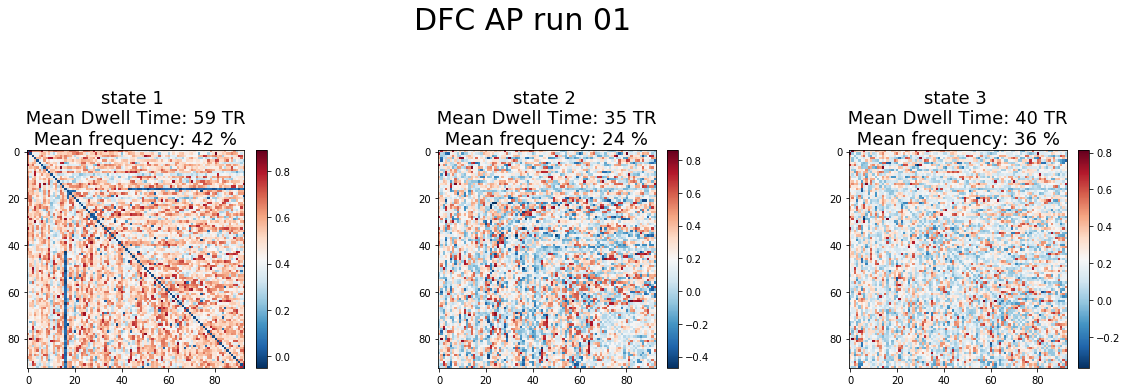

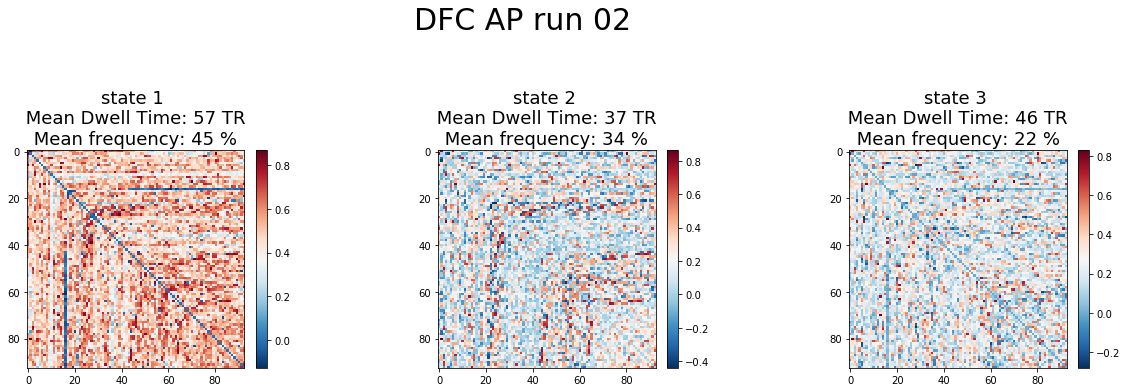

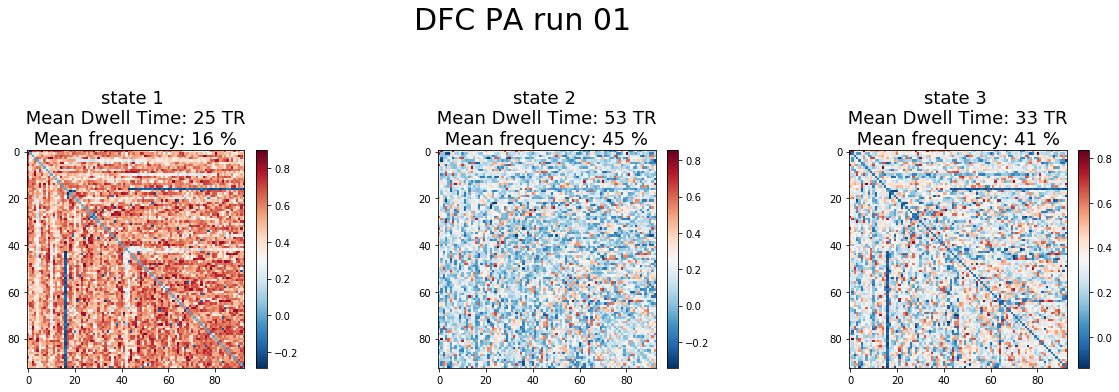

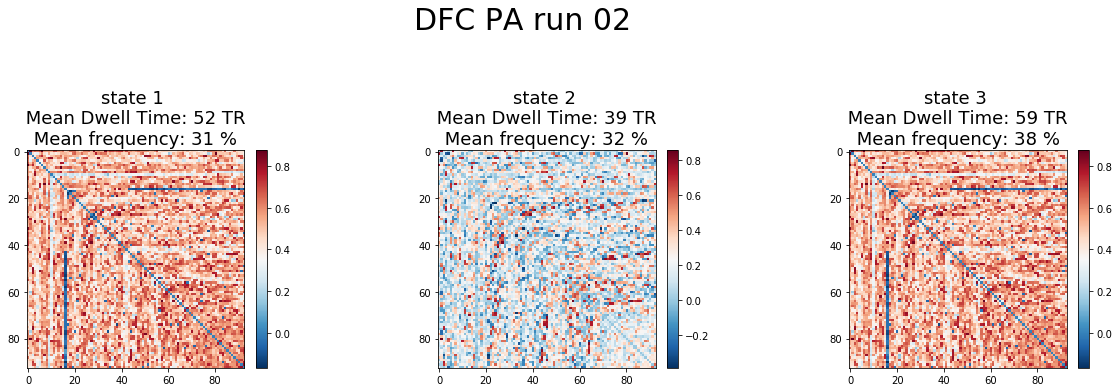

In [23]:
for r in np.arange(1,3):
    plot_dfc(dfc_AP['run_0%d'%r].states,grp_dwell=grp_dwell_AP['run_0%d'%r],
             grp_freq=grp_freq_AP['run_0%d'%r],title='DFC AP run 0%d'%r)
for r in np.arange(1,3):
    plot_dfc(dfc_PA['run_0%d'%r].states,grp_dwell=grp_dwell_PA['run_0%d'%r],
             grp_freq=grp_freq_PA['run_0%d'%r],title='DFC PA run 0%d'%r)